### Logistic Regression

Determine the content and context features that relate to a tweet being shared or liked, using the entire population of tweets (752,496).

In [1]:
import os
import re
import time
import pickle
import mglearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from io import StringIO
from IPython.display import display

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from statsmodels.tools.tools import add_constant
from statsmodels.iolib.summary2 import summary_col
from scipy.stats import pearsonr

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import make_scorer, confusion_matrix

%matplotlib inline
sns.set(font_scale=1.25)
sns.set(style='white')
sns.set(style='whitegrid', color_codes=True)
pd.options.display.max_columns = 0
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', -1)

C:\Users\Periwynkle\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Load the SML-classified population dataset that includes the random sample.

In [2]:
tweets_with_IVs = os.path.expanduser('~/Dropbox/University of Oxford/Oxford Internet Institute/Dissertation/Data/full_population_df_with_IVs.h5')
hdf = pd.HDFStore(tweets_with_IVs)
df = hdf["tweets"]
df

,created_at,date,day_numeric,day,time,hour,hour_binned,days_before_ref,account_age,source,in_reply_to_user_id,coordinates,tweet_url,text,user_name,user_screen_name,user_description,user_verified,user_followers_count,user_friends_count,user_created_at,user_location,user_time_zone,user_statuses_count,user_favourites_count,hashtags,hashtags_count,mentions,mentions_count,urls,urls_count,urls_count_binary,media_urls,media_type_count,media_type_count_binary,media_type,photo,video,gif,position,organisation,message_type,question,emotion,resolution,issue,rt_count,like_count,rt_count_binary,like_count_binary
720824890891218946,2016-04-15 05:03:40,2016-04-15,4,Friday,05:03:40,05,Small hours,69.00,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720824890891218946,The best couple 4Ever 💟 💟 #Britin #QAF https://t.co/s4SOtpA8ya,Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057.00,206.00,2015-01-19,None,NaN,4543.00,2580.00,"[britin, qaf]",2.00,[],0.00,[],0.00,0,[pic.twitter.com/s4SOtpA8ya],1.00,1,[animated_gif],0,0,1,Remain,0,Division,0,1,0,0,13.00,32.00,1,1
720825272447021057,2016-04-15 05:05:11,2016-04-15,4,Friday,05:05:11,05,Small hours,69.00,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720825272447021057,AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF https://t.co/8Tf8FDVUnh,Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057.00,206.00,2015-01-19,None,NaN,4545.00,2580.00,"[britin, qaf]",2.00,[],0.00,[],0.00,0,[pic.twitter.com/8Tf8FDVUnh],1.00,1,[animated_gif],0,0,1,Leave,0,Division,0,1,0,0,8.00,29.00,1,1
720825677277061120,2016-04-15 05:06:48,2016-04-15,4,Friday,05:06:48,05,Small hours,69.00,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825677277061120,#VoteLeave and Austerity Will End https://t.co/OiGzHH50f6 #eureferendum #euref #Remain https://t.co/xRPciOzi6Z,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369.00,2821.00,2007-10-26,All major cities worldwide,London,3442.00,5.00,"[voteleave, eureferendum, euref, remain]",4.00,[],0.00,[https://t.co/OiGzHH50f6],1.00,1,[pic.twitter.com/xRPciOzi6Z],1.00,1,[photo],1,0,0,Leave,0,Division,0,1,0,1,0.00,nan,0,0
720825685481119744,2016-04-15 05:06:50,2016-04-15,4,Friday,05:06:50,05,Small hours,69.00,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825685481119744,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain https://t.co/0pSeyDUbNm,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369.00,2821.00,2007-10-26,All major cities worldwide,London,3443.00,5.00,"[brexit, remain, eureferendum]",3.00,[],0.00,[https://t.co/0pSeyDUbNm],1.00,1,[],0.00,0,[],0,0,0,Leave,0,Other,0,0,0,0,0.00,nan,0,0
720825751310716930,2016-04-15 05:07:06,2016-04-15,4,Friday,05:07:06,05,Small hours,69.00,0.06,Tweet Jukebox,None,None,https://www.twitter.com/RemainShame/status/720825751310716930,Do you want live in EU dictatorship? https://t.co/A2E0AHAZpj #EUreferendum #Brexit #Remain #strongerin #INcampaign https://t.co/N4fL7ko0ye,BrexitNeverSurrender,RemainShame,The Spirit of a Great Man Lives On,False,74.00,60.00,2016-03-22,"Kent, England",NaN,715.00,20.00,"[eureferendum, brexit, remain, strongerin, incampaign]",5.00,[],0.00,[https://t.co/A2E0AHAZpj],1.00,1,[pic.twitter.com/N4fL7ko0ye],1.00,1,[photo],1,0,0,Leave,0,Division,1,1,0,1,0.00,nan,0,0
720825780058521600,2016-04-15 05:07:12,2016-04-15,4,Friday,05:07:12,05,Small hours,69.00,0.03,Tweet Jukebox,None,None,https://www.twitter.com/EU_Failed/status/720825780058521600,Selling Britain Off On the Cheap is Good Says #EU https://t.co/iXoWvXz3ok #eureferendum #euref #brexit #VOTELEAVE https://t.co/zgVlzxXdSa,EUfailed,EU_Failed,None,False,26.00,20.00,2016-04-02,None,NaN,78.00,1.00,"[eu, eureferendum, euref, brexit, vote

In [3]:
print(df.shape)
print(list(df.columns))

(741411, 50)
['created_at', 'date', 'day_numeric', 'day', 'time', 'hour', 'hour_binned', 'days_before_ref', 'account_age', 'source', 'in_reply_to_user_id', 'coordinates', 'tweet_url', 'text', 'user_name', 'user_screen_name', 'user_description', 'user_verified', 'user_followers_count', 'user_friends_count', 'user_created_at', 'user_location', 'user_time_zone', 'user_statuses_count', 'user_favourites_count', 'hashtags', 'hashtags_count', 'mentions', 'mentions_count', 'urls', 'urls_count', 'urls_count_binary', 'media_urls', 'media_type_count', 'media_type_count_binary', 'media_type', 'photo', 'video', 'gif', 'position', 'organisation', 'message_type', 'question', 'emotion', 'resolution', 'issue', 'rt_count', 'like_count', 'rt_count_binary', 'like_count_binary']


In [4]:
df.describe()

,days_before_ref,account_age,user_followers_count,user_friends_count,user_statuses_count,user_favourites_count,hashtags_count,mentions_count,urls_count,media_type_count,rt_count,like_count
count,741411.00,741411.00,741411.00,741411.00,741411.00,741411.00,741411.00,741411.00,741411.00,741411.00,741411.00,278143.00
mean,17.68,3.90,4600.39,1535.25,40639.45,3890.77,2.56,0.29,0.35,0.25,4.22,9.01
std,17.17,2.59,74662.67,6392.37,180207.83,10332.97,1.72,0.66,0.48,0.51,48.03,86.64
min,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,3.00,1.33,110.00,160.00,1038.00,59.00,1.00,0.00,0.00,0.00,0.00,0.00
50%,13.00,4.25,471.00,533.00,4525.00,521.00,2.00,0.00,0.00,0.00,0.00,1.00
75%,27.00,6.13,1778.00,1593.00,16257.00,2882.00,3.00,0.00,1.00,0.00,1.00,5.00
max,69.00,9.95,22752666.00,1568791.00,6206247.00,390609.00,21.00,10.00,4.00,4.00,14258.00,18107.00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 741411 entries, 720824890891218946 to 744999435848007680
Data columns (total 50 columns):
created_at                 741411 non-null datetime64[ns]
date                       741411 non-null object
day_numeric                741411 non-null object
day                        741411 non-null object
time                       741411 non-null object
hour                       741411 non-null object
hour_binned                741411 non-null object
days_before_ref            741411 non-null float64
account_age                741411 non-null float64
source                     741409 non-null object
in_reply_to_user_id        39001 non-null object
coordinates                2134 non-null object
tweet_url                  741411 non-null object
text                       741411 non-null object
user_name                  741411 non-null object
user_screen_name           741411 non-null object
user_description           637529 non-null object
use

These exploratory calcuations show that tweets that were shared were published an average of 20 days before the referendum (vs. 16), from users with more followers and friends than tweets that were not shared. Interestingly, tweets that were not shared are from users with a significantly higher status count (44,719 vs. 33,844). Account age, hashtag count, mention count, and URL count averages are about the same. Media type count is higher for tweets that were shared. This aligns with the results from the random sample.

In [6]:
df.groupby('rt_count_binary').mean()

,days_before_ref,account_age,user_verified,user_followers_count,user_friends_count,user_statuses_count,user_favourites_count,hashtags_count,mentions_count,urls_count,media_type_count,rt_count,like_count
rt_count_binary,,,,,,,,,,,,,
0,16.22,3.86,0.00,2197.67,1100.69,44719.42,3047.10,2.62,0.27,0.37,0.20,0.00,nan
1,20.10,3.96,0.05,8602.31,2259.05,33843.96,5295.97,2.45,0.33,0.31,0.35,11.24,9.01


In [3]:
hour_binned_cat = pd.get_dummies(df['hour_binned'])
day_cat = pd.get_dummies(df['day'])
position_cat = pd.get_dummies(df['position'])
message_type_cat = pd.get_dummies(df['message_type'])

In [4]:
df = df.join(hour_binned_cat)
df = df.join(day_cat)
df = df.join(position_cat)
df = df.join(message_type_cat)
df.head()

,created_at,date,day_numeric,day,time,hour,hour_binned,days_before_ref,account_age,source,in_reply_to_user_id,coordinates,tweet_url,text,user_name,user_screen_name,user_description,user_verified,user_followers_count,user_friends_count,user_created_at,user_location,user_time_zone,user_statuses_count,user_favourites_count,hashtags,hashtags_count,mentions,mentions_count,urls,urls_count,urls_count_binary,media_urls,media_type_count,media_type_count_binary,media_type,photo,video,gif,position,organisation,message_type,question,emotion,resolution,issue,rt_count,like_count,rt_count_binary,like_count_binary,Afternoon,Morning,Night,Small hours,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Ambiguous,Leave,Remain,Division,Identification,Other
720824890891218946,2016-04-15 05:03:40,2016-04-15,4,Friday,05:03:40,05,Small hours,69.00,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720824890891218946,The best couple 4Ever 💟 💟 #Britin #QAF https://t.co/s4SOtpA8ya,Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057.00,206.00,2015-01-19,None,NaN,4543.00,2580.00,"[britin, qaf]",2.00,[],0.00,[],0.00,0,[pic.twitter.com/s4SOtpA8ya],1.00,1,[animated_gif],0,0,1,Remain,0,Division,0,1,0,0,13.00,32.00,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0
720825272447021057,2016-04-15 05:05:11,2016-04-15,4,Friday,05:05:11,05,Small hours,69.00,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720825272447021057,AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF https://t.co/8Tf8FDVUnh,Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057.00,206.00,2015-01-19,None,NaN,4545.00,2580.00,"[britin, qaf]",2.00,[],0.00,[],0.00,0,[pic.twitter.com/8Tf8FDVUnh],1.00,1,[animated_gif],0,0,1,Leave,0,Division,0,1,0,0,8.00,29.00,1,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0
720825677277061120,2016-04-15 05:06:48,2016-04-15,4,Friday,05:06:48,05,Small hours,69.00,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825677277061120,#VoteLeave and Austerity Will End https://t.co/OiGzHH50f6 #eureferendum #euref #Remain https://t.co/xRPciOzi6Z,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369.00,2821.00,2007-10-26,All major cities worldwide,London,3442.00,5.00,"[voteleave, eureferendum, euref, remain]",4.00,[],0.00,[https://t.co/OiGzHH50f6],1.00,1,[pic.twitter.com/xRPciOzi6Z],1.00,1,[photo],1,0,0,Leave,0,Division,0,1,0,1,0.00,nan,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0
720825685481119744,2016-04-15 05:06:50,2016-04-15,4,Friday,05:06:50,05,Small hours,69.00,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825685481119744,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain https://t.co/0pSeyDUbNm,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369.00,2821.00,2007-10-26,All major cities worldwide,London,3443.00,5.00,"[brexit, remain, eureferendum]",3.00,[],0.00,[https://t.co/0pSeyDUbNm],1.00,1,[],0.00,0,[],0,0,0,Leave,0,Other,0,0,0,0,0.00,nan,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1
720825751310716930,2016-04-15 05:07:06,2016-04-15,4,Friday,05:07:06,05,Small hours,69.00,0.06,Tweet Jukebox,None,None,https://www.twitter.com/RemainShame/status/720825751310716930,Do you want live in EU dictatorship? https://t.co/A2E0AHAZpj #EUreferendum #Brexit #Remain #strongerin #INcampaign https://t.co/N4fL7ko0ye,BrexitNeverSurrender,RemainShame,The Spirit of a Great Man Lives On,False,74.00,60.00,2016-03-22,"Kent, England",NaN,715.00,20.00,"[eureferendum, brexit, remain, strongerin, incampaign]",5.00,[],0.00,[https://t.co/A2E0AHAZpj],1.00,1,[pic.twitter.com/N4fL7ko0ye],1.00,1,[photo],1,0,0,Leave,0,Division,1,1,0,1,0.00,nan,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0


In [5]:
df.Afternoon = df.Afternoon.astype('object')
df.Morning = df.Morning.astype('object')
df.Night = df.Night.astype('object')
df['Small hours'] = df['Small hours'].astype('object')

df.Monday = df.Monday.astype('object')
df.Tuesday = df.Tuesday.astype('object')
df.Wednesday = df.Wednesday.astype('object')
df.Thursday = df.Thursday.astype('object')
df.Friday = df.Friday.astype('object')
df.Saturday = df.Saturday.astype('object')
df.Sunday = df.Sunday.astype('object')

df.Ambiguous = df.Ambiguous.astype('object')
df.Leave = df.Leave.astype('object')
df.Remain = df.Remain.astype('object')

df.Division = df.Division.astype('object')
df.Identification = df.Identification.astype('object')
df.Other = df.Other.astype('object')

In [10]:
df.describe()

,days_before_ref,account_age,user_followers_count,user_friends_count,user_statuses_count,user_favourites_count,hashtags_count,mentions_count,urls_count,media_type_count,rt_count,like_count
count,741411.00,741411.00,741411.00,741411.00,741411.00,741411.00,741411.00,741411.00,741411.00,741411.00,741411.00,278143.00
mean,17.68,3.90,4600.39,1535.25,40639.45,3890.77,2.56,0.29,0.35,0.25,4.22,9.01
std,17.17,2.59,74662.67,6392.37,180207.83,10332.97,1.72,0.66,0.48,0.51,48.03,86.64
min,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,3.00,1.33,110.00,160.00,1038.00,59.00,1.00,0.00,0.00,0.00,0.00,0.00
50%,13.00,4.25,471.00,533.00,4525.00,521.00,2.00,0.00,0.00,0.00,0.00,1.00
75%,27.00,6.13,1778.00,1593.00,16257.00,2882.00,3.00,0.00,1.00,0.00,1.00,5.00
max,69.00,9.95,22752666.00,1568791.00,6206247.00,390609.00,21.00,10.00,4.00,4.00,14258.00,18107.00


Coefficients of user_followers_count are 0 in all models, which translates to an odds ratio of 1. Statistically significant, but essentially meaningless. Coefficients and odds ratios increase after the variable is log10 transformed.

In [6]:
df['log10_followers_count'] = np.log10(df['user_followers_count']+1) # Need to add one because the log of 0 is -inf.
df['log10_statuses_count'] = np.log10(df['user_statuses_count']+1) 
df['log10_friends_count'] = np.log10(df['user_friends_count']+1) 
df['log10_rt_count'] = np.log10(df['rt_count']+1) 

In [12]:
df.describe()

,days_before_ref,account_age,user_followers_count,user_friends_count,user_statuses_count,user_favourites_count,hashtags_count,mentions_count,urls_count,media_type_count,rt_count,like_count,log10_followers_count,log10_statuses_count,log10_friends_count,log10_rt_count
count,741411.00,741411.00,741411.00,741411.00,741411.00,741411.00,741411.00,741411.00,741411.00,741411.00,741411.00,278143.00,741411.00,741411.00,741411.00,741411.00
mean,17.68,3.90,4600.39,1535.25,40639.45,3890.77,2.56,0.29,0.35,0.25,4.22,9.01,2.64,3.60,2.60,0.26
std,17.17,2.59,74662.67,6392.37,180207.83,10332.97,1.72,0.66,0.48,0.51,48.03,86.64,0.92,0.97,0.86,0.43
min,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.30,0.00,0.00
25%,3.00,1.33,110.00,160.00,1038.00,59.00,1.00,0.00,0.00,0.00,0.00,0.00,2.05,3.02,2.21,0.00
50%,13.00,4.25,471.00,533.00,4525.00,521.00,2.00,0.00,0.00,0.00,0.00,1.00,2.67,3.66,2.73,0.00
75%,27.00,6.13,1778.00,1593.00,16257.00,2882.00,3.00,0.00,1.00,0.00,1.00,5.00,3.25,4.21,3.20,0.30
max,69.00,9.95,22752666.00,1568791.00,6206247.00,390609.00,21.00,10.00,4.00,4.00,14258.00,18107.00,7.36,6.79,6.20,4.15


In [7]:
reg_columns = ['rt_count_binary', 
               'Ambiguous', 'Leave', 'Remain', 
               'user_verified', 'log10_followers_count', 'account_age', 
               'Small hours', 'Morning', 'Afternoon', 'Night',  
               'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',   
               'days_before_ref', 
               'hashtags_count', 'mentions_count', 'urls_count_binary', 
               'media_type_count_binary', 'photo', 'video', 'gif', 
               'organisation', 
               'Identification', 'Division', 'Other',
               'emotion', 'issue', 'resolution', 
               'question']

df_reg = df[reg_columns]
df_reg.columns.values

array(['rt_count_binary', 'Ambiguous', 'Leave', 'Remain', 'user_verified',
       'log10_followers_count', 'account_age', 'Small hours', 'Morning',
       'Afternoon', 'Night', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday', 'days_before_ref',
       'hashtags_count', 'mentions_count', 'urls_count_binary',
       'media_type_count_binary', 'photo', 'video', 'gif', 'organisation',
       'Identification', 'Division', 'Other', 'emotion', 'issue',
       'resolution', 'question'], dtype=object)

In [8]:
reg_vars = df_reg.columns.values.tolist()
control_vars = reg_vars[:19]
control_disc_vars = reg_vars[:27]
control_content_style_vars = reg_vars[:19] + reg_vars[27:34]
excluded_vars = ['rt_count_binary', 'Ambiguous', 'user_verified', 'Night', 'Saturday', 'media_type_count_binary', 'Other', 'Identification']

X_control = [i for i in control_vars if i not in excluded_vars]
X_control_disc = [i for i in control_disc_vars if i not in excluded_vars]
X_control_content_style = [i for i in control_content_style_vars if i not in excluded_vars]
X_all = [i for i in reg_vars if i not in excluded_vars]

print("Control variables:", X_control)
print("Control and discoverability variables:", X_control_disc)
print("Control and content/style variables:", X_control_content_style)
print("All variables:", X_all)

Control variables: ['Leave', 'Remain', 'log10_followers_count', 'account_age', 'Small hours', 'Morning', 'Afternoon', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday', 'days_before_ref']
Control and discoverability variables: ['Leave', 'Remain', 'log10_followers_count', 'account_age', 'Small hours', 'Morning', 'Afternoon', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday', 'days_before_ref', 'hashtags_count', 'mentions_count', 'urls_count_binary', 'photo', 'video', 'gif', 'organisation']
Control and content/style variables: ['Leave', 'Remain', 'log10_followers_count', 'account_age', 'Small hours', 'Morning', 'Afternoon', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday', 'days_before_ref', 'Division', 'emotion', 'issue', 'resolution', 'question']
All variables: ['Leave', 'Remain', 'log10_followers_count', 'account_age', 'Small hours', 'Morning', 'Afternoon', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday', 'days_before_ref'

In [9]:
X1 = df_reg[X_control]
X2 = df_reg[X_control_disc]
X3 = df_reg[X_control_content_style]
X4 = df_reg[X_all]
y_rt = df_reg['rt_count_binary']

In [10]:
logit_model_rt = sm.Logit(y_rt.astype(float), X1.astype(float))
result_control_rt = logit_model_rt.fit()
result_control_rt.summary2()

Optimization terminated successfully.
         Current function value: 0.623983
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                 Logit             No. Iterations:    5.0000     
Dependent Variable:    rt_count_binary   Pseudo R-squared:  0.057      
Date:                  2018-11-22 22:06  AIC:               925283.5229
No. Observations:      741411            BIC:               925444.7512
Df Model:              13                Log-Likelihood:    -4.6263e+05
Df Residuals:          741397            LL-Null:           -4.9055e+05
Converged:             1.0000            Scale:             1.0000     
-----------------------------------------------------------------------
                       Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Leave                 -0.7838   0.0090  -86.6685 0.0000 -0.8015 -0.7660
Remain                -0.5046   0.0093  -54.2773 0.0000 -0.5228 -0.4863
log10_followers_count  0.6196   0.0030  205.3238 0.0000  0.6137  0.6255
account_age           -0.1088   0.0011 -100.8471 0.0000 -0.1109 -0.1067
Small hours           -0.7138   0.0140  -51.0903 0.0000 -0.7411 -0.6864
Morning               -0.2618   0.0062  -42.0166 0.0000 -0.2740 -0.2496
Afternoon             -0.2780   0.0059  -46.7951 0.0000 -0.2896 -0.2664
Monday                -0.9949   0.0095 -104.5532 0.0000 -1.0136 -0.9763
Tuesday               -1.1597   0.0087 -132.9726 0.0000 -1.1768 -1.1426
Wednesday             -1.1446   0.0086 -133.5229 0.0000 -1.1614 -1.1278
Thursday              -1.0547   0.0097 -108.4667 0.0000 -1.0737 -1.0356
Friday                -0.9527   0.0104  -91.4977 0.0000 -0.9732 -0.9323
Sunday                -0.9331   0.0100  -93.1143 0.0000 -0.9527 -0.9135
days_before_ref        0.0046   0.0001   31.0508 0.0000  0.0043  0.0049
=======================================================================

"""

In [11]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.exp(result_control_rt.params)

Leave                   0.457
Remain                  0.604
log10_followers_count   1.858
account_age             0.897
Small hours             0.490
Morning                 0.770
Afternoon               0.757
Monday                  0.370
Tuesday                 0.314
Wednesday               0.318
Thursday                0.348
Friday                  0.386
Sunday                  0.393
days_before_ref         1.005
dtype: float64

In [12]:
logit_model_rt = sm.Logit(y_rt.astype(float), X2.astype(float))
result_control_disc_rt = logit_model_rt.fit()
result_control_disc_rt.summary2()

Optimization terminated successfully.
         Current function value: 0.600126
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                 Logit             No. Iterations:    6.0000     
Dependent Variable:    rt_count_binary   Pseudo R-squared:  0.093      
Date:                  2018-11-22 22:06  AIC:               889922.7653
No. Observations:      741411            BIC:               890164.6078
Df Model:              20                Log-Likelihood:    -4.4494e+05
Df Residuals:          741390            LL-Null:           -4.9055e+05
Converged:             1.0000            Scale:             1.0000     
-----------------------------------------------------------------------
                       Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Leave                 -0.7344   0.0094  -78.0549 0.0000 -0.7528 -0.7159
Remain                -0.5817   0.0097  -60.1898 0.0000 -0.6006 -0.5627
log10_followers_count  0.6067   0.0033  183.9545 0.0000  0.6002  0.6132
account_age           -0.0967   0.0011  -85.4127 0.0000 -0.0989 -0.0945
Small hours           -0.4582   0.0143  -32.1234 0.0000 -0.4862 -0.4303
Morning               -0.1973   0.0064  -30.6502 0.0000 -0.2099 -0.1847
Afternoon             -0.2242   0.0062  -36.2756 0.0000 -0.2363 -0.2121
Monday                -0.8002   0.0098  -81.2903 0.0000 -0.8195 -0.7809
Tuesday               -0.9753   0.0090 -107.9932 0.0000 -0.9930 -0.9576
Wednesday             -0.9601   0.0089 -108.2212 0.0000 -0.9775 -0.9427
Thursday              -0.8610   0.0101  -85.5159 0.0000 -0.8807 -0.8413
Friday                -0.7547   0.0108  -70.1435 0.0000 -0.7758 -0.7336
Sunday                -0.7333   0.0104  -70.7953 0.0000 -0.7536 -0.7130
days_before_ref        0.0069   0.0002   44.6974 0.0000  0.0066  0.0072
hashtags_count        -0.1318   0.0016  -83.9094 0.0000 -0.1349 -0.1287
mentions_count         0.0258   0.0039    6.6281 0.0000  0.0182  0.0334
urls_count_binary     -0.3620   0.0058  -62.6292 0.0000 -0.3733 -0.3507
photo                  0.5074   0.0062   81.8962 0.0000  0.4953  0.5195
video                  0.9652   0.0372   25.9602 0.0000  0.8923  1.0381
gif                    0.2472   0.0406    6.0931 0.0000  0.1677  0.3267
organisation           1.9890   0.0240   82.8909 0.0000  1.9419  2.0360
=======================================================================

"""

In [13]:
np.exp(result_control_disc_rt.params)

Leave                   0.480
Remain                  0.559
log10_followers_count   1.834
account_age             0.908
Small hours             0.632
Morning                 0.821
Afternoon               0.799
Monday                  0.449
Tuesday                 0.377
Wednesday               0.383
Thursday                0.423
Friday                  0.470
Sunday                  0.480
days_before_ref         1.007
hashtags_count          0.877
mentions_count          1.026
urls_count_binary       0.696
photo                   1.661
video                   2.625
gif                     1.280
organisation            7.308
dtype: float64

In [14]:
logit_model_rt = sm.Logit(y_rt.astype(float), X3.astype(float))
result_control_content_style_rt = logit_model_rt.fit()
result_control_content_style_rt.summary2()

Optimization terminated successfully.
         Current function value: 0.621469
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                 Logit             No. Iterations:    5.0000     
Dependent Variable:    rt_count_binary   Pseudo R-squared:  0.061      
Date:                  2018-11-22 22:06  AIC:               921565.5419
No. Observations:      741411            BIC:               921784.3518
Df Model:              18                Log-Likelihood:    -4.6076e+05
Df Residuals:          741392            LL-Null:           -4.9055e+05
Converged:             1.0000            Scale:             1.0000     
-----------------------------------------------------------------------
                       Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Leave                 -0.5038   0.0114  -44.1474 0.0000 -0.5261 -0.4814
Remain                -0.3018   0.0107  -28.2281 0.0000 -0.3228 -0.2809
log10_followers_count  0.6397   0.0031  208.8335 0.0000  0.6337  0.6457
account_age           -0.1101   0.0011 -101.4548 0.0000 -0.1122 -0.1079
Small hours           -0.6654   0.0140  -47.4184 0.0000 -0.6929 -0.6379
Morning               -0.2345   0.0063  -37.3822 0.0000 -0.2468 -0.2222
Afternoon             -0.2535   0.0060  -42.3720 0.0000 -0.2652 -0.2418
Monday                -0.9186   0.0097  -95.1666 0.0000 -0.9376 -0.8997
Tuesday               -1.0815   0.0089 -121.8936 0.0000 -1.0989 -1.0641
Wednesday             -1.0736   0.0087 -123.1712 0.0000 -1.0907 -1.0565
Thursday              -0.9808   0.0099  -99.4873 0.0000 -1.0001 -0.9615
Friday                -0.8791   0.0105  -83.3844 0.0000 -0.8998 -0.8584
Sunday                -0.8552   0.0102  -84.1909 0.0000 -0.8752 -0.8353
days_before_ref        0.0058   0.0002   38.1968 0.0000  0.0055  0.0061
Division              -0.1340   0.0066  -20.4398 0.0000 -0.1469 -0.1212
emotion               -0.2250   0.0072  -31.2302 0.0000 -0.2391 -0.2109
issue                 -0.1242   0.0052  -23.8435 0.0000 -0.1344 -0.1140
resolution            -0.4025   0.0132  -30.4621 0.0000 -0.4284 -0.3766
question              -0.2165   0.0078  -27.8144 0.0000 -0.2317 -0.2012
=======================================================================

"""

In [15]:
np.exp(result_control_content_style_rt.params)

Leave                   0.604
Remain                  0.739
log10_followers_count   1.896
account_age             0.896
Small hours             0.514
Morning                 0.791
Afternoon               0.776
Monday                  0.399
Tuesday                 0.339
Wednesday               0.342
Thursday                0.375
Friday                  0.415
Sunday                  0.425
days_before_ref         1.006
Division                0.875
emotion                 0.799
issue                   0.883
resolution              0.669
question                0.805
dtype: float64

In [16]:
logit_model_rt = sm.Logit(y_rt.astype(float), X4.astype(float))
result_all_rt = logit_model_rt.fit()
result_all_rt.summary2()

Optimization terminated successfully.
         Current function value: 0.599014
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                 Logit             No. Iterations:    6.0000     
Dependent Variable:    rt_count_binary   Pseudo R-squared:  0.095      
Date:                  2018-11-22 22:06  AIC:               888283.5607
No. Observations:      741411            BIC:               888582.9847
Df Model:              25                Log-Likelihood:    -4.4412e+05
Df Residuals:          741385            LL-Null:           -4.9055e+05
Converged:             1.0000            Scale:             1.0000     
-----------------------------------------------------------------------
                       Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Leave                 -0.5525   0.0119  -46.4051 0.0000 -0.5759 -0.5292
Remain                -0.4258   0.0112  -38.1598 0.0000 -0.4477 -0.4039
log10_followers_count  0.6153   0.0033  185.4783 0.0000  0.6088  0.6218
account_age           -0.0962   0.0011  -84.8227 0.0000 -0.0985 -0.0940
Small hours           -0.4391   0.0143  -30.7239 0.0000 -0.4672 -0.4111
Morning               -0.1856   0.0065  -28.7273 0.0000 -0.1983 -0.1730
Afternoon             -0.2120   0.0062  -34.1841 0.0000 -0.2242 -0.1998
Monday                -0.7574   0.0099  -76.2232 0.0000 -0.7768 -0.7379
Tuesday               -0.9289   0.0091 -101.6302 0.0000 -0.9468 -0.9109
Wednesday             -0.9175   0.0090 -102.2652 0.0000 -0.9351 -0.9000
Thursday              -0.8205   0.0102  -80.7667 0.0000 -0.8404 -0.8006
Friday                -0.7134   0.0108  -65.7795 0.0000 -0.7347 -0.6922
Sunday                -0.6904   0.0104  -66.0704 0.0000 -0.7109 -0.6699
days_before_ref        0.0074   0.0002   47.7255 0.0000  0.0071  0.0077
hashtags_count        -0.1270   0.0016  -80.0003 0.0000 -0.1301 -0.1239
mentions_count         0.0263   0.0039    6.7033 0.0000  0.0186  0.0340
urls_count_binary     -0.3587   0.0059  -60.7095 0.0000 -0.3703 -0.3471
photo                  0.4996   0.0063   79.7837 0.0000  0.4874  0.5119
video                  0.9655   0.0372   25.9591 0.0000  0.8926  1.0384
gif                    0.2307   0.0406    5.6882 0.0000  0.1512  0.3102
organisation           1.9798   0.0240   82.4170 0.0000  1.9327  2.0269
Division              -0.0662   0.0068   -9.6961 0.0000 -0.0795 -0.0528
emotion               -0.2072   0.0074  -27.9670 0.0000 -0.2217 -0.1927
issue                  0.0041   0.0055    0.7436 0.4571 -0.0067  0.0148
resolution            -0.2781   0.0135  -20.5451 0.0000 -0.3047 -0.2516
question              -0.1804   0.0079  -22.7387 0.0000 -0.1960 -0.1649
=======================================================================

"""

In [17]:
np.exp(result_all_rt.params)

Leave                   0.575
Remain                  0.653
log10_followers_count   1.850
account_age             0.908
Small hours             0.645
Morning                 0.831
Afternoon               0.809
Monday                  0.469
Tuesday                 0.395
Wednesday               0.399
Thursday                0.440
Friday                  0.490
Sunday                  0.501
days_before_ref         1.007
hashtags_count          0.881
mentions_count          1.027
urls_count_binary       0.699
photo                   1.648
video                   2.626
gif                     1.259
organisation            7.241
Division                0.936
emotion                 0.813
issue                   1.004
resolution              0.757
question                0.835
dtype: float64

In [18]:
info_dict={'McFadden R2': lambda x: "{:.2f}".format(x.prsquared),
           'AIC': lambda x: "{:.2f}".format(x.aic),
           'BIC': lambda x: "{:.2f}".format(x.bic),
           'Number of Observations': lambda x: "{0:d}".format(int(x.nobs))}

rt_models = summary_col([result_control_rt, 
                         result_control_disc_rt, 
                         result_control_content_style_rt, 
                         result_all_rt], 
                         stars=True, 
                         info_dict=info_dict,
                         float_format='%0.3f',
                         model_names=['Control', 'Discoverability', 'Content & Style', 'Full Model'],
                         regressor_order=X_all)

rt_models.add_title('Logistic Regression Models for Retweet Count (Binary)')

print(rt_models.as_text())
#print(rt_models.as_latex())

           Logistic Regression Models for Retweet Count (Binary)
                        Control  Discoverability Content & Style Full Model
---------------------------------------------------------------------------
Leave                  -0.784*** -0.734***       -0.504***       -0.553*** 
                       (0.009)   (0.009)         (0.011)         (0.012)   
Remain                 -0.505*** -0.582***       -0.302***       -0.426*** 
                       (0.009)   (0.010)         (0.011)         (0.011)   
log10_followers_count  0.620***  0.607***        0.640***        0.615***  
                       (0.003)   (0.003)         (0.003)         (0.003)   
account_age            -0.109*** -0.097***       -0.110***       -0.096*** 
                       (0.001)   (0.001)         (0.001)         (0.001)   
Small hours            -0.714*** -0.458***       -0.665***       -0.439*** 
                       (0.014)   (0.014)         (0.014)         (0.014)   
Morning                

### Regression Diagnostics

Need to check for 1) multicollinearity and 2) influential variables/outliers.

**Multicollinearity**

In [19]:
continuous_columns = ['user_followers_count', 'user_friends_count',  
                      'user_statuses_count', 'account_age', 'days_before_ref']

df_continuous = df[continuous_columns]

In [26]:
#spm = pd.plotting.scatter_matrix(df_continuous, alpha=0.2, figsize=(15,15), diagonal='hist')
#plt.suptitle('Scatterplot Matrix of Continuous Variables', y=0.90, fontsize=15);
#plt.savefig('Scatterplot Matrix of Continuous Variables.jpg', bbox_inches='tight')

In [20]:
df_continuous.corr()

,user_followers_count,user_friends_count,user_statuses_count,account_age,days_before_ref
user_followers_count,1.000,0.215,0.022,0.053,0.002
user_friends_count,0.215,1.000,0.113,0.091,0.017
user_statuses_count,0.022,0.113,1.000,0.174,0.082
account_age,0.053,0.091,0.174,1.000,-0.068
days_before_ref,0.002,0.017,0.082,-0.068,1.000


In [21]:
pval_mat = np.zeros((df_continuous.shape[1], df_continuous.shape[1]))

for i in range(df_continuous.shape[1]):    
    for j in range(df_continuous.shape[1]):        
        corrtest = pearsonr(df_continuous[df_continuous.columns[i]], df_continuous[df_continuous.columns[j]])  
        pval_mat[i,j] = corrtest[1]

df_pvals = pd.DataFrame(pval_mat, columns=df_continuous.columns, index=df_continuous.columns)
df_pvals

,user_followers_count,user_friends_count,user_statuses_count,account_age,days_before_ref
user_followers_count,0.000,0.000,0.000,0.000,0.066
user_friends_count,0.000,0.000,0.000,0.000,0.000
user_statuses_count,0.000,0.000,0.000,0.000,0.000
account_age,0.000,0.000,0.000,0.000,0.000
days_before_ref,0.066,0.000,0.000,0.000,0.000


In [22]:
log10_continuous_columns = ['log10_followers_count', 'log10_friends_count',  
                            'log10_statuses_count', 'account_age', 'days_before_ref']

df_log10_continuous = df[log10_continuous_columns]

In [30]:
#spm_log10 = pd.tools.plotting.scatter_matrix(df_log10_continuous, alpha=0.2, figsize=(15,15), diagonal='hist')
#plt.suptitle('Scatterplot Matrix of Log-transformed Continuous Variables', y=0.90, fontsize=15)
#plt.savefig('Scatterplot Matrix of Log-transformed Continuous Variables.jpg', bbox_inches='tight')

In [23]:
df_log10_continuous.corr()

,log10_followers_count,log10_friends_count,log10_statuses_count,account_age,days_before_ref
log10_followers_count,1.000,0.807,0.674,0.390,0.051
log10_friends_count,0.807,1.000,0.517,0.387,0.043
log10_statuses_count,0.674,0.517,1.000,0.375,0.024
account_age,0.390,0.387,0.375,1.000,-0.068
days_before_ref,0.051,0.043,0.024,-0.068,1.000


In [24]:
pval_mat = np.zeros((df_log10_continuous.shape[1], df_log10_continuous.shape[1]))

for i in range(df_log10_continuous.shape[1]):    
    for j in range(df_log10_continuous.shape[1]):        

        corrtest = pearsonr(df_log10_continuous[df_log10_continuous.columns[i]], df_log10_continuous[df_log10_continuous.columns[j]])  
        pval_mat[i,j] = corrtest[1]

df_pvals = pd.DataFrame(pval_mat, columns=df_log10_continuous.columns, index=df_log10_continuous.columns)
df_pvals

,log10_followers_count,log10_friends_count,log10_statuses_count,account_age,days_before_ref
log10_followers_count,0.000,0.000,0.000,0.000,0.000
log10_friends_count,0.000,0.000,0.000,0.000,0.000
log10_statuses_count,0.000,0.000,0.000,0.000,0.000
account_age,0.000,0.000,0.000,0.000,0.000
days_before_ref,0.000,0.000,0.000,0.000,0.000


In [25]:
df.Ambiguous = df.Ambiguous.astype('int')
df.Leave = df.Leave.astype('int')
df.Remain = df.Remain.astype('int')

df.user_verified = df.user_verified.astype('int')

df.Afternoon = df.Afternoon.astype('int')
df.Morning = df.Morning.astype('int')
df.Night = df.Night.astype('int')
df['Small hours'] = df['Small hours'].astype('int')

df.Monday = df.Monday.astype('int')
df.Tuesday = df.Tuesday.astype('int')
df.Wednesday = df.Wednesday.astype('int')
df.Thursday = df.Thursday.astype('int')
df.Friday = df.Friday.astype('int')
df.Saturday = df.Saturday.astype('int')
df.Sunday = df.Sunday.astype('int')

df.urls_count_binary = df.urls_count_binary.astype('int')
df.photo = df.photo.astype('int')
df.video = df.video.astype('int')
df.gif = df.gif.astype('int')
df.organisation = df.organisation.astype('int')

df.Division = df.Division.astype('int')
df.Identification = df.Identification.astype('int')
df.Other = df.Other.astype('int')

df.emotion = df.emotion.astype('int')
df.issue = df.issue.astype('int')
df.resolution = df.resolution.astype('int')

df.question = df.question.astype('int')

In [26]:
df_control = df[X_control]
control_corr_mat = df_control.corr()

df_control_disc = df[X_control_disc]
control_disc_corr_mat = df_control_disc.corr()

df_control_content_style = df[X_control_content_style]
control_content_style_corr_mat = df_control_content_style.corr()

In [27]:
df_all = df[X_all]

df_all = df_all.rename(index=str, columns={'user_verified': 'User verified', 
                                           'log10_followers_count': 'User followers count (log10)',
                                           'account_age': 'Account age',
                                           'days_before_ref': 'Days before referendum',
                                           'hashtags_count': 'Hashtag count',
                                           'mentions_count': 'Mention count',
                                           'urls_count_binary': 'URL count (binary)',
                                           'photo': 'Photo',
                                           'video': 'Video',
                                           'gif': 'GIF',
                                           'organisation': 'Organisation',
                                           'emotion': 'Emotion',
                                           'issue': 'Issue',
                                           'resolution': 'Resolution',
                                           'question': 'Question'})

print(df_all.columns.values)
corr_mat = df_all.corr()

['Leave' 'Remain' 'User followers count (log10)' 'Account age'
 'Small hours' 'Morning' 'Afternoon' 'Monday' 'Tuesday' 'Wednesday'
 'Thursday' 'Friday' 'Sunday' 'Days before referendum' 'Hashtag count'
 'Mention count' 'URL count (binary)' 'Photo' 'Video' 'GIF' 'Organisation'
 'Division' 'Emotion' 'Issue' 'Resolution' 'Question']


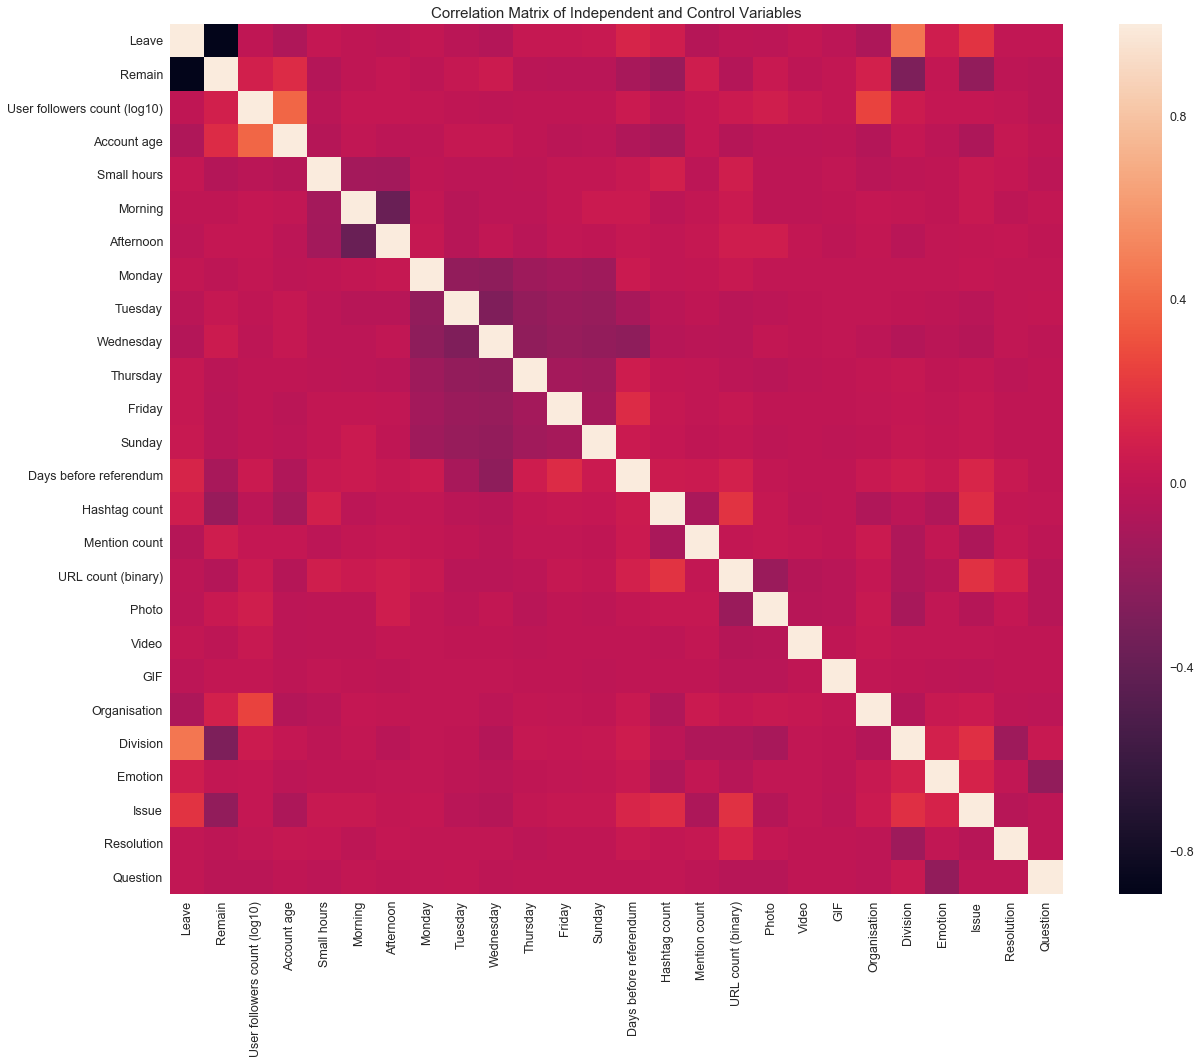

In [28]:
sns.set(font_scale=1.25)
fig = plt.figure(figsize=(20,16))
corrmat = sns.heatmap(corr_mat)
plt.title('Correlation Matrix of Independent and Control Variables') 
plt.show()
fig = corrmat.get_figure()
fig.savefig('Bivariate Correlation Matrix.jpg', bbox_inches='tight')

In [29]:
corr_mat
#corr_mat.to_csv("correlation_matrix_population.csv")

,Leave,Remain,User followers count (log10),Account age,Small hours,Morning,Afternoon,Monday,Tuesday,Wednesday,Thursday,Friday,Sunday,Days before referendum,Hashtag count,Mention count,URL count (binary),Photo,Video,GIF,Organisation,Division,Emotion,Issue,Resolution,Question
Leave,1.000,-0.892,-0.002,-0.074,0.018,-0.004,-0.019,0.011,-0.022,-0.056,0.026,0.026,0.033,0.118,0.075,-0.048,-0.012,-0.020,0.011,-0.013,-0.081,0.457,0.072,0.191,0.007,0.003
Remain,-0.892,1.000,0.085,0.151,-0.055,0.002,0.019,-0.011,0.026,0.058,-0.024,-0.031,-0.032,-0.107,-0.172,0.074,-0.052,0.040,-0.007,0.016,0.095,-0.289,0.012,-0.204,-0.006,-0.025
User followers count (log10),-0.002,0.085,1.000,0.390,-0.026,0.022,0.018,0.014,0.001,-0.006,0.001,-0.004,0.000,0.051,-0.016,0.019,0.048,0.079,0.035,0.011,0.255,0.056,0.017,0.020,0.003,-0.027
Account age,-0.074,0.151,0.390,1.000,-0.048,0.007,-0.014,-0.006,0.025,0.030,-0.003,-0.025,-0.016,-0.068,-0.111,0.022,-0.046,-0.018,-0.019,-0.006,-0.055,0.024,-0.014,-0.084,0.025,-0.001
Small hours,0.018,-0.055,-0.026,-0.048,1.000,-0.117,-0.130,-0.003,-0.014,-0.013,-0.008,0.016,0.011,0.033,0.085,-0.019,0.076,-0.012,-0.006,0.008,-0.032,-0.008,-0.003,0.037,0.023,-0.016
Morning,-0.004,0.002,0.022,0.007,-0.117,1.000,-0.380,0.013,-0.040,-0.017,-0.019,0.013,0.047,0.051,-0.013,0.011,0.052,-0.006,-0.008,-0.003,0.017,0.014,-0.003,0.039,-0.005,0.011
Afternoon,-0.019,0.019,0.018,-0.014,-0.130,-0.380,1.000,0.026,-0.039,0.009,-0.033,0.004,-0.001,0.029,0.006,0.028,0.072,0.072,0.012,-0.006,0.016,-0.034,0.004,0.017,0.017,-0.003
Monday,0.011,-0.011,0.014,-0.006,-0.003,0.013,0.026,1.000,-0.202,-0.217,-0.149,-0.129,-0.139,0.049,0.006,0.010,0.038,0.008,0.005,0.002,0.004,0.009,0.005,0.022,0.004,0.003
Tuesday,-0.022,0.026,0.001,0.025,-0.014,-0.040,-0.039,-0.202,1.000,-0.280,-0.193,-0.167,-0.180,-0.108,-0.021,-0.005,-0.033,-0.016,-0.002,0.004,0.006,0.001,-0.006,-0.032,0.003,0.012
Wednesday,-0.056,0.058,-0.006,0.030,-0.013,-0.017,0.009,-0.217,-0.280,1.000,-0.207,-0.179,-0.193,-0.217,-0.041,-0.024,-0.029,0.010,-0.000,0.008,-0.016,-0.051,-0.021,-0.049,0.007,-0.008


In [30]:
pval_mat = np.zeros((corr_mat.shape[1], corr_mat.shape[1]))

for i in range(corr_mat.shape[1]):    
    for j in range(corr_mat.shape[1]):        
        corrtest = pearsonr(corr_mat[corr_mat.columns[i]], corr_mat[corr_mat.columns[j]])  
        pval_mat[i,j] = corrtest[1]

df_pvals = pd.DataFrame(pval_mat, columns=corr_mat.columns, index=corr_mat.columns)
df_pvals
#df_pvals.to_csv("correlation_matrix_pvals_population.csv")

,Leave,Remain,User followers count (log10),Account age,Small hours,Morning,Afternoon,Monday,Tuesday,Wednesday,Thursday,Friday,Sunday,Days before referendum,Hashtag count,Mention count,URL count (binary),Photo,Video,GIF,Organisation,Division,Emotion,Issue,Resolution,Question
Leave,0.000,0.000,0.602,0.285,0.778,0.981,0.783,0.906,0.802,0.504,0.761,0.743,0.710,0.229,0.302,0.392,0.967,0.602,0.995,0.800,0.312,0.000,0.583,0.032,0.761,0.967
Remain,0.000,0.000,0.386,0.142,0.585,0.997,0.816,0.886,0.765,0.489,0.764,0.697,0.692,0.201,0.107,0.360,0.625,0.584,0.977,0.835,0.289,0.001,0.840,0.021,0.888,0.837
User followers count (log10),0.602,0.386,0.000,0.001,0.493,0.999,0.958,0.985,0.914,0.928,0.955,0.814,0.872,0.881,0.423,0.964,0.861,0.692,0.959,0.795,0.057,0.953,0.893,0.640,0.745,0.584
Account age,0.285,0.142,0.001,0.000,0.464,0.986,0.832,0.873,0.737,0.641,0.902,0.660,0.765,0.286,0.146,0.880,0.433,0.910,0.772,0.863,0.831,0.780,0.749,0.175,0.988,0.875
Small hours,0.778,0.585,0.493,0.464,0.000,0.369,0.300,0.955,0.929,0.909,0.963,0.891,0.937,0.863,0.403,0.668,0.546,0.738,0.823,0.947,0.567,0.920,0.848,0.767,0.917,0.803
Morning,0.981,0.997,0.999,0.986,0.369,0.000,0.000,0.939,0.781,0.882,0.920,0.919,0.682,0.766,0.834,0.959,0.842,0.764,0.838,0.888,0.973,0.943,0.896,0.856,0.841,0.982
Afternoon,0.783,0.816,0.958,0.832,0.300,0.000,0.000,0.821,0.802,0.858,0.784,0.992,0.911,0.992,0.974,0.873,0.722,0.582,0.988,0.855,0.962,0.614,0.924,0.907,0.926,0.873
Monday,0.906,0.886,0.985,0.873,0.955,0.939,0.821,0.000,0.258,0.218,0.441,0.522,0.476,0.593,0.938,0.962,0.733,0.977,0.986,0.956,0.981,0.963,0.992,0.834,0.991,0.971
Tuesday,0.802,0.765,0.914,0.737,0.929,0.781,0.802,0.258,0.000,0.128,0.290,0.341,0.320,0.365,0.811,0.985,0.739,0.942,0.969,0.929,0.927,0.966,0.973,0.723,0.961,0.877
Wednesday,0.504,0.489,0.928,0.641,0.909,0.882,0.858,0.218,0.128,0.000,0.232,0.276,0.273,0.045,0.671,0.919,0.767,0.806,0.940,0.869,0.954,0.551,0.856,0.541,0.883,0.982


In [39]:
df_all_with_constant = add_constant(df_all)
pd.Series([variance_inflation_factor(df_all_with_constant.values, i) for i in range(df_all_with_constant.shape[1])], 
          index=df_all_with_constant.columns)

const                          46.830
Leave                          6.918 
Remain                         6.251 
User followers count (log10)   1.354 
Account age                    1.282 
Small hours                    1.079 
Morning                        1.243 
Afternoon                      1.257 
Monday                         2.107 
Tuesday                        2.609 
Wednesday                      2.772 
Thursday                       2.047 
Friday                         1.824 
Sunday                         1.931 
Days before referendum         1.142 
Hashtag count                  1.139 
Mention count                  1.033 
URL count (binary)             1.178 
Photo                          1.085 
Video                          1.009 
GIF                            1.004 
Organisation                   1.134 
Division                       1.507 
Emotion                        1.101 
Issue                          1.157 
Resolution                     1.052 
Question    

In [40]:
vif_df = pd.DataFrame()
vif_df['vif'] = [variance_inflation_factor(df_all_with_constant.values, i) for i in range(df_all_with_constant.shape[1])]
vif_df['tolerance'] = 1/vif_df['vif']
vif_df['feature'] = df_all_with_constant.columns
vif_df.sort_values('vif', ascending=False)
#vif_df.to_csv('vif_population.csv')

In [41]:
w, v = np.linalg.eig(corr_mat)
w

array([2.40673561, 0.07773572, 0.1113724 , 0.46960789, 1.52068191,
       1.51119492, 0.50154603, 0.62760346, 0.65904051, 1.39778584,
       0.71670759, 0.76427573, 0.84806335, 1.29875061, 0.90972634,
       1.26394073, 1.21628047, 0.97228487, 0.99790831, 1.03601658,
       1.15944846, 1.14285383, 1.12233777, 1.11097333, 1.07175468,
       1.08537306])

In [42]:
print(v[1])

[-0.55726296 -0.67383325 -0.00199928  0.00565266  0.14538542  0.02283821
 -0.03335412 -0.28402808  0.11850979  0.06664691 -0.01961916  0.02543076
  0.18287968  0.04137588  0.02547955 -0.03675258  0.07620722  0.00851167
  0.03988007 -0.04492149  0.07905188 -0.10183713  0.08040481 -0.16823841
 -0.10690657 -0.05428142]


In [43]:
vector = list(v[1])
for i in vector:
    if i > 0.3 or i < -0.3:
        print(i)
        print(corr_mat.columns[vector.index(i)])

-0.5572629552382034
Leave
-0.6738332493110142
Remain


In [44]:
print(np.linalg.det(control_corr_mat))
print(np.linalg.det(control_disc_corr_mat))
print(np.linalg.det(control_content_style_corr_mat))
print(np.linalg.det(corr_mat))

0.029167614511274642
0.02032217699628454
0.016875063886696275
0.010628737989515073


In [45]:
print(np.linalg.cond(control_corr_mat))
print(np.linalg.cond(control_disc_corr_mat))
print(np.linalg.cond(control_content_style_corr_mat))
print(np.linalg.cond(corr_mat))

19.790246810842913
21.885900214794844
28.67644602632776
30.96048424674737


**Outliers**

In [31]:
ols_rt = sm.OLS(df['log10_rt_count'].astype(float), X4.astype(float))
ols_result = ols_rt.fit()
print(ols_result.summary())

                            OLS Regression Results                            
Dep. Variable:         log10_rt_count   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                 2.431e+04
Date:                Thu, 22 Nov 2018   Prob (F-statistic):               0.00
Time:                        22:08:06   Log-Likelihood:            -3.0497e+05
No. Observations:              741411   AIC:                         6.100e+05
Df Residuals:                  741385   BIC:                         6.103e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Leave                     0.00

In [47]:
#fig, ax = plt.subplots(figsize=(24,24))
#fig = sm.graphics.plot_leverage_resid2(ols_result, ax=ax)
#plt.title('Leverage vs. Normalised Residuals Squared', fontsize=20)
#plt.ylabel('Leverage', fontsize=20)
#plt.xlabel('Normalised Residuals Squared', fontsize=20);
#fig.savefig('Leverage-Residuals Squared Plot.jpg', bbox_inches='tight')

In [48]:
#fig, ax = plt.subplots(figsize=(24,24))
#fig = sm.graphics.influence_plot(ols_result, alpha=0.01, ax=ax, criterion='cooks')
#plt.title('Influence Plot', fontsize=20)
#plt.ylabel('Studentised Residuals', fontsize=20)
#plt.xlabel('H Leverage', fontsize=20);
#fig.savefig('Influence Plot.jpg', bbox_inches='tight')

In [32]:
(c, p) = ols_result.get_influence().cooks_distance

In [35]:
print(len(c))

741411


In [ ]:
df['cooks_d'] = c

In [48]:
df_cooksd = df.sort_values('cooks_d', ascending=False)[['created_at', 'tweet_url', 'text', 'user_screen_name', 'user_description', 'user_followers_count', 'rt_count', 'media_type_count']]
df_cooksd.iloc[175:200]

,created_at,tweet_url,text,user_screen_name,user_description,user_followers_count,rt_count,media_type_count
744416634224291840,2016-06-19 07:28:50,https://www.twitter.com/Juliet777777/status/744416634224291840,#CAMERON #BRITAIN EVEN WORSE WHEN TURKEY JOINS MORE MUSLIM THUGS ARRIVE -UK WOMEN ATTACKED LIKE #GERMANY #VoteLeave https://t.co/K1hp5RnsAU,Juliet777777,"Better live one day as a tiger, than a thousand as a sheep. PEGIDA ,PRO Israel , FX TRADER All thats for Evil to prevail good men do nothing",20308.000,111.000,1.000
723657424960368640,2016-04-23 00:39:09,https://www.twitter.com/iVoteLeave/status/723657424960368640,Our message is loud and clear: Britain is #BetterOffOut and we must #VoteLeave and #TakeControl! Join us to spread this message!,iVoteLeave,Our message is loud and clear: Britain is #BetterOffOut and we must #VoteLeave and #TakeControl! Join us to spread this message,0.000,525.000,0.000
744552911737237504,2016-06-19 16:30:21,https://www.twitter.com/beleaveuk/status/744552911737237504,Forging new trade deals with the rest of the world is vital to our future prosperity. #BeLeave in global horizons. https://t.co/Di73NTdLuz,beleaveuk,BeLeave is the group representing young people in the campaign for a 'leave' vote in the EU referendum. Putting forward an optimistic case for leaving. #BeLeave,3430.000,183.000,1.000
745530026032930816,2016-06-22 09:13:04,https://www.twitter.com/EuroGuido/status/745530026032930816,Business leaders come out for #Remain https://t.co/BwCkr5CXz8,EuroGuido,Here for the referendum.,7669.000,48.000,1.000
744949866980327424,2016-06-20 18:47:43,https://www.twitter.com/Leavethe_EU/status/744949866980327424,vote_leave: Immigration is good for our country. Let's #VoteLeave and implement a fairer system. #InOrOut https://t.co/yAr7XSs7mJ #brexit,Leavethe_EU,#No2EU ~ #Brexit ~ #BelieveInBritain ~ #BetterOffOut ~ #labour #conservative @vote_leave #ukip #leaveEUofficial https://www.youtube.com/watch?v=UTMxfAkxfQ0,6476.000,48.000,1.000
734391772659486722,2016-05-22 15:33:37,https://www.twitter.com/vote_leave/status/734391772659486722,WATCH: Paxman confirms that most of our laws are made by the EU. Let's #VoteLeave and #TakeControl on 23 June. https://t.co/huvu7CHB9j,vote_leave,Vote Leave - campaign for a 'leave' vote in EU referendum. End supremacy of EU law. Take control. Invest in NHS & science. The safer choice.,44027.000,729.000,1.000
745575800116772864,2016-06-22 12:14:57,https://www.twitter.com/vote_leave/status/745575800116772864,WATCH: Chief adviser to Turkey’s President Erdogan calls out the PM on his misleading comments on Turkey #VoteLeave https://t.co/384BcJ0csN,vote_leave,Vote Leave - campaign for a 'leave' vote in EU referendum. End supremacy of EU law. Take control. Invest in NHS & science. The safer choice.,66573.000,674.000,1.000
745738620426928129,2016-06-22 23:01:56,https://www.twitter.com/aaronselliott/status/745738620426928129,Who's #VoteLeave? RT if you are with us! #Brexit @DanHannanMEP @JuliaHB1 @IsabelOakeshott @JohnCleese @LouiseMensch https://t.co/Ix9MyrubeM,aaronselliott,Intergovernmental cooperation not supranational dictatorship. Proud Brit & supporter of freedom and democracy. Love Europe & the World. Hate the EU. #VoteLeave,98.000,104.000,1.000
745385215531483136,2016-06-21 23:37:38,https://www.twitter.com/Englishpapist/status/745385215531483136,Ignore the banker-backed scaremongers and make 24th of June our Independence Day #bbcdebate #takecontrol https://t.co/CSBY28BkAB,Englishpapist,Brexit The Movie https://www.youtube.com/watch?v=UTMxfAkxfQ0,2293.000,35.000,1.000
740810645176766464,2016-06-09 08:39:56,https://www.twitter.com/chrisg0000/status/740810645176766464,"Osborne caught lying (again), this time #europhile dominated Select Committee called him out #VoteLeave https://t.co/cplodBQdYy",chrisg0000,Proud to be British. Right of centre. Pro-Monarchy. Anti-EU. Anti-Racist. NeoCon.,3559.000,104.000,1.000


Creating a summary frame for the entire population takes too long - the below script does not work.

In [ ]:
influence = OLSInfluence(ols_result)
influence_df = influence.summary_frame()
influence_df.head()
influence_df.to_csv('influence_stats_population.csv')

In [ ]:
influence_stats = os.path.expanduser('~/Dropbox/University of Oxford/Oxford Internet Institute/Dissertation/Data/influence_stats_population.csv')
influence_df = pd.read_csv(influence_stats)
influence_df.set_index('tweet_id', inplace=True)
influence_df.head()

In [ ]:
influence_df.describe()

In [ ]:
influence_df.sort_values('cooks_d', ascending=False).head()

In [ ]:
high_cooksd = df.loc[influence_df['cooks_d'] > 0.002]
print(high_cooksd.shape)
high_cooksd[['tweet_url', 'text', 'user_followers_count', 'rt_count', 'user_name', 'organisation', 'media_type_count_binary']]

In [ ]:
influence_df.sort_values('hat_diag', ascending=False).head()

In [ ]:
high_leverage = df.loc[influence_df['hat_diag'] > 0.03]
print(high_leverage.shape)
high_leverage

In [ ]:
high_residuals = df.loc[influence_df['student_resid'] > 2]
print(high_residuals.shape)
high_residuals[['text', 'user_followers_count', 'rt_count', 'user_name', 'organisation', 'media_type_count_binary']]

In [ ]:
high_leverage.index

In [ ]:
df_without_leverage = df[~df.index.isin(high_leverage.index)]
df_without_leverage

In [ ]:
y_rt = df_without_leverage['rt_count_binary']
X5 = df_without_leverage[X_all]
logit_model_rt2 = sm.Logit(y_rt.astype(float), X5.astype(float))
result_all_without_leverage_rt = logit_model_rt2.fit()
result_all_without_leverage_rt.summary2()

In [ ]:
np.exp(result_all_without_leverage_rt.params)

In [ ]:
rt_models = summary_col([result_all_rt, result_all_without_leverage_rt], 
                         stars=True, 
                         info_dict=info_dict,
                         float_format='%0.3f',
                         model_names=['Full Model', 'Without High Leverage'])

rt_models.add_title('Logistic Regression Models for Retweeted')
print(rt_models)